In [1]:
import os
import sys

# Notebook /notebooks klasöründe çalışıyor, proje kökü bir üst klasör
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Project root:", project_root)

Project root: /Users/ipekdalgic/Desktop/alzheimer-mri-classification


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.dataset import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# Her sınıftan 50 örnek alarak küçük bir deney seti hazırlıyoruz.
X, y, class_names = load_dataset(
    data_root="../data/raw",
    use_autocontrast=True,
    normalize=True,
    limit_per_class=50,
)

print("X shape:", X.shape)  # (N, H, W)
print("y shape:", y.shape)
print("Unique labels:", set(y))

Loaded 50 images from class 'MildDemented' (label=1).
Loaded 50 images from class 'ModerateDemented' (label=1).
Loaded 50 images from class 'NonDemented' (label=0).
Loaded 50 images from class 'VeryMildDemented' (label=1).
Final dataset shape: (200, 208, 176)
Label vector shape: (200,)
X shape: (200, 208, 176)
y shape: (200,)
Unique labels: {np.int32(0), np.int32(1)}


In [4]:
# Görüntüleri 2D'den (H, W) 1D vektöre çeviriyoruz
N, H, W = X.shape
X_flat = X.reshape(N, H * W)  # (N, H*W)

print("X_flat shape:", X_flat.shape)

# Eğitim ve test setine ayır
X_train, X_test, y_train, y_test = train_test_split(
    X_flat,
    y,
    test_size=0.2,     # %20 test
    random_state=42,
    stratify=y,        # sınıf oranlarını koru
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

X_flat shape: (200, 36608)
Train size: 160
Test size: 40


In [5]:
baseline_clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
)

baseline_clf.fit(X_train, y_train)

y_pred_base = baseline_clf.predict(X_test)

acc_base = accuracy_score(y_test, y_pred_base)
print("=== Model 1: Baseline Logistic Regression ===")
print("Test accuracy:", acc_base)
print("\nClassification report:")
print(classification_report(y_test, y_pred_base))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_base))

=== Model 1: Baseline Logistic Regression ===
Test accuracy: 0.65

Classification report:
              precision    recall  f1-score   support

           0       0.17      0.10      0.12        10
           1       0.74      0.83      0.78        30

    accuracy                           0.65        40
   macro avg       0.45      0.47      0.45        40
weighted avg       0.59      0.65      0.62        40

Confusion matrix:
[[ 1  9]
 [ 5 25]]


In [6]:
balanced_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight="balanced",  # az olan sınıfa daha fazla ağırlık
    )),
])

balanced_clf.fit(X_train, y_train)

y_pred_bal = balanced_clf.predict(X_test)

acc_bal = accuracy_score(y_test, y_pred_bal)
print("=== Model 2: Scaler + Balanced Logistic Regression ===")
print("Test accuracy:", acc_bal)
print("\nClassification report:")
print(classification_report(y_test, y_pred_bal))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_bal))

=== Model 2: Scaler + Balanced Logistic Regression ===
Test accuracy: 0.7

Classification report:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25        10
           1       0.76      0.87      0.81        30

    accuracy                           0.70        40
   macro avg       0.55      0.53      0.53        40
weighted avg       0.66      0.70      0.67        40

Confusion matrix:
[[ 2  8]
 [ 4 26]]


In [7]:
n_components = 100  # PCA ile boyutu 100'e indiriyoruz

pca_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=n_components)),
    ("logreg", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight="balanced",
    )),
])

pca_clf.fit(X_train, y_train)

y_pred_pca = pca_clf.predict(X_test)

acc_pca = accuracy_score(y_test, y_pred_pca)
print("=== Model 3: Scaler + PCA + Balanced Logistic Regression ===")
print("Test accuracy:", acc_pca)
print("\nClassification report:")
print(classification_report(y_test, y_pred_pca))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_pca))

# PCA'nın ne kadar varyans tuttuğuna bakalım
pca_step = pca_clf.named_steps["pca"]
explained_var = pca_step.explained_variance_ratio_.sum()
print(f"\nTotal explained variance with {n_components} components: {explained_var:.2f}")

=== Model 3: Scaler + PCA + Balanced Logistic Regression ===
Test accuracy: 0.7

Classification report:
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        10
           1       0.78      0.83      0.81        30

    accuracy                           0.70        40
   macro avg       0.58      0.57      0.57        40
weighted avg       0.68      0.70      0.69        40

Confusion matrix:
[[ 3  7]
 [ 5 25]]

Total explained variance with 100 components: 0.96


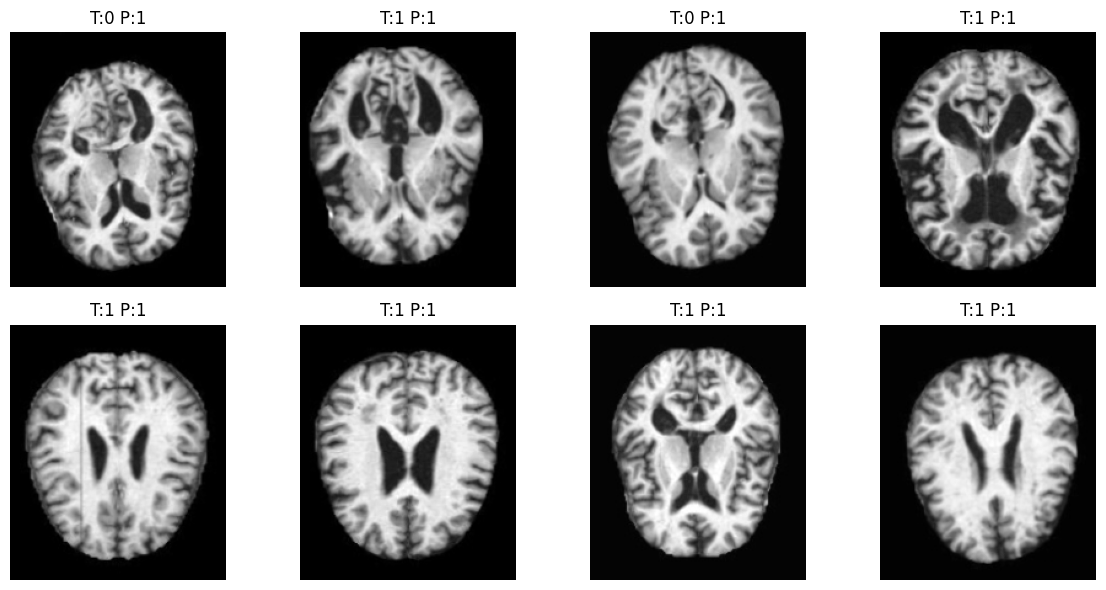

In [8]:
n_show = 8
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(axes.ravel()):
    if i >= n_show:
        break
    idx = i
    img = X_test[idx].reshape(H, W)
    true_label = y_test[idx]
    pred_label = y_pred_pca[idx]  # istersen y_pred_bal veya y_pred_base de kullanabilirsin

    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(f"T:{true_label} P:{pred_label}")

plt.tight_layout()
plt.show()